In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from generate_nndatasets import *
from nets import *
from configs import *
from random import shuffle
from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [16]:
BSIZE = 1
HISTLEN = 6
NUMSEGS = 9
HIDDENSIZE=25
TEST_SEG = 0
TARGET = 0

In [5]:
device = torch.device("cpu")

# seq = Sequence(
#     batchsize=BSIZE,
#     historylen=HISTLEN,
#     numsegments=NUMSEGS,
#     hiddensize=HIDDENSIZE).to(device).double()

criterion = nn.MSELoss()

# seq.eval()
seq = torch.load('checkpoints/%s' % Sequence.name)

In [11]:
use_segment = SEGMENTS[TEST_SEG]
numsegments = len(use_segment['locations'])
print('# segments', numsegments)
(_, test_data), (_, test_metadata) = create_dataset(use_segment)

# segments 9
[9/9] Loading segment...    
Time Steps: 4320
Available: 99.2%  Location: Priti Sood Sayeed
Available: 98.6%  Location: Arun Duggal
Available: 98.9%  Location: U.S. Embassy
Available: 98.8%  Location: Segel Design
Available: 98.6%  Location: Jamun
Available: 84.9%  Location: Vihara
Available: 99.0%  Location: Prateek Mittal
Available: 98.4%  Location: Nischal
Available: 96.8%  Location: NIta
Total missing: 3.0%
Train test split:  3456 / 865


In [14]:
print('B/c padding, metadata len may not be equal:', test_data.shape[1], len(test_metadata[0]))

B/c padding, metadata len may not be equal: 865 831


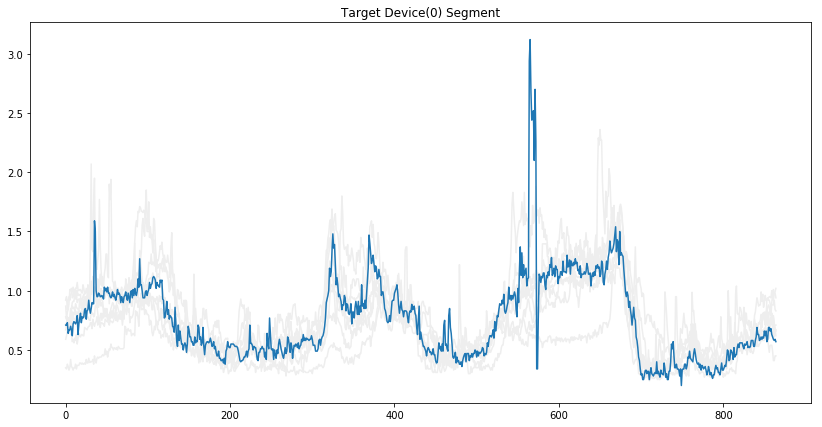

In [22]:
plt.figure(figsize=(14, 7))
plt.gca().set_title('Target Device(%d) Segment' % TARGET)
for sii, seg in enumerate(test_data):
    if sii == TARGET: continue
    plt.plot(seg, color='#EEEEEE')
plt.plot(test_data[TARGET], color='C0')
plt.show()
plt.close()

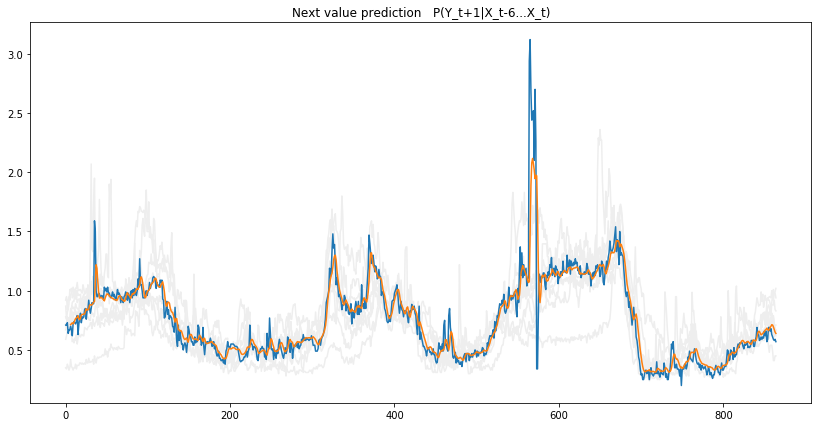

In [31]:
next_preds = []
lastii = test_data.shape[1] - HISTLEN
for ii in range(0, lastii):
    input = test_data[:, ii:ii+HISTLEN]
    input = np.transpose(input, [1, 0]) # seq first order
    input = torch.from_numpy(input).unsqueeze(1) # add batch axis in middle
    state = seq.init_lstms(batch=1)
    ypred, _ = seq(input, state)
    next_preds.append(ypred)
    
    sys.stdout.write('[%d/%d] Next value predictions...     \r' % (ii+1, lastii))

plt.figure(figsize=(14, 7))
plt.gca().set_title('Next value prediction   P(Y_t+1|X_t-6...X_t)')
for sii, seg in enumerate(test_data):
    if sii == TARGET: continue
    plt.plot(seg, color='#EEEEEE')
plt.plot(test_data[TARGET], color='C0')
ninds = [ii for ii in range(HISTLEN, test_data.shape[1])]
assert len(ninds) == len(next_preds)
plt.plot(ninds, next_preds, color='C1')
plt.show()
plt.close()

In [102]:
def forecast(start, future=12): # default 1hr forecast
    # here start: referes to start index of history, not start of future
    assert start < test_data.shape[1] - HISTLEN - future
    assert start+HISTLEN+future <= test_data.shape[1]
    # initially filled up to HISTLEN -> will gradually fill up future
    placeholder = -np.ones((test_data.shape[0], HISTLEN + future))
    
    placeholder[:, :] = test_data[:, start:start+HISTLEN+future]
    placeholder[TARGET, HISTLEN:] = -1
    
    lossavg = 0
    for ff in range(future):
        input = placeholder[:, ff:ff+HISTLEN]
        assert input.shape[1] == HISTLEN
        input = np.transpose(input, [1, 0]) # seq first order
        input = torch.from_numpy(input).unsqueeze(1) # add batch axis in middle
        
        state = seq.init_lstms(batch=1)
        ypred, _ = seq(input, state)
        ylbl = torch.tensor(test_data[TARGET, HISTLEN+ff], dtype=torch.double)
        lossavg += criterion(ypred.squeeze(), ylbl).detach().squeeze().cpu().numpy()
        placeholder[TARGET, HISTLEN + ff] = ypred.detach().squeeze().cpu().numpy()
    lossavg /= future
    return placeholder[TARGET, HISTLEN:], lossavg

FUTURE = 12
# lastii = test_data.shape[1] - HISTLEN - FUTURE
# all_fcasts = []
# all_losses = []
# for ii in range(0, lastii):
#     ypreds, lavg = forecast(ii, future=FUTURE)
#     all_fcasts.append(ypreds)
#     all_losses.append(lavg)
#     break

#     sys.stdout.write('[%d/%d] Next value predictions...     \r' % (ii+1, lastii))
def time_range(tstr, start, length):
    t0 = time.mktime(datetime.strptime(tstr, '%m/%d/%Y').timetuple())
    t_start = t0 + start * 5 * 60 # 5min interval
    t_start = datetime.fromtimestamp(t_start).strftime("%m/%d/%Y %H:%M:%S")
    t_end = t0 + (start + length) * 5 * 60 # 5min interval
    t_end = datetime.fromtimestamp(t_end).strftime("%m/%d/%Y %H:%M:%S")
    return t_start, t_end

def plot_forecast(start, ypreds, loss, subplot=False, ylim=(0, 100)):
    showlen = HISTLEN+len(ypreds)
    if not subplot: plt.figure(figsize=(14, 7))
    plt.gca().set_title('Forecast t+1...t+%d,  t=%d,  loss=%.3f' % (
        len(ypreds), start+HISTLEN, loss*100))
    for sii, seg in enumerate(test_data):
        if sii == TARGET: continue
        plt.plot(100*seg[start:start+showlen], color='#EEEEEE')
    plt.plot(100*test_data[TARGET, start:start+showlen], color='C0')
    finds = [ii for ii in range(HISTLEN, showlen)]
    assert len(finds) == len(ypreds)
    plt.plot(finds, ypreds*100, color='C1')
    plt.ylim(ylim[0], ylim[1])
    readable_range = time_range(use_segment['start'], start, showlen)
    plt.xticks([0, showlen-1], readable_range)
    if not subplot:plt.show()
    if not subplot:plt.close()
    
# plot_forecast(0, all_fcasts[0], all_losses[0])

In [81]:
all_fcasts = []
all_losses = []
lastii = test_data.shape[1] - HISTLEN - FUTURE
for ii in range(0, lastii):
    ypreds, lavg = forecast(ii, future=FUTURE)
    all_fcasts.append(ypreds)
    all_losses.append(lavg)

    sys.stdout.write('[%d/%d] Forecast     \r' % (ii+1, lastii))
    sys.stdout.flush()

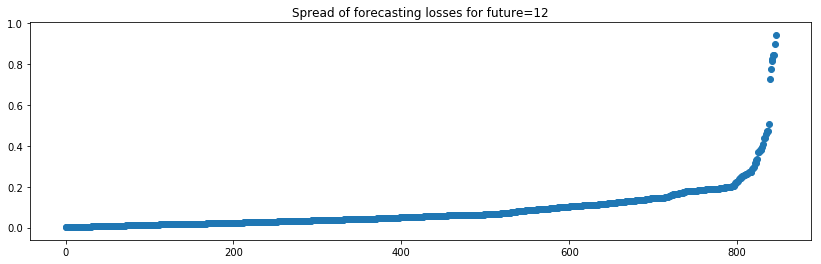

In [96]:
plt.figure(figsize=(14, 4))
plt.gca().set_title('Spread of forecasting losses for future=%d' % FUTURE)
loss_dist = sorted(np.array(all_losses))
plt.scatter(list(range(len(loss_dist))), loss_dist)
plt.show()
plt.close()

In [83]:
best2worst = np.argsort(all_losses)
print(best2worst[:10], best2worst[-10:])
assert len(best2worst) == len(all_losses)

[131 132 134 838 837 130 842 843 133 836] [559 664 565 567 566 564 560 563 562 561]


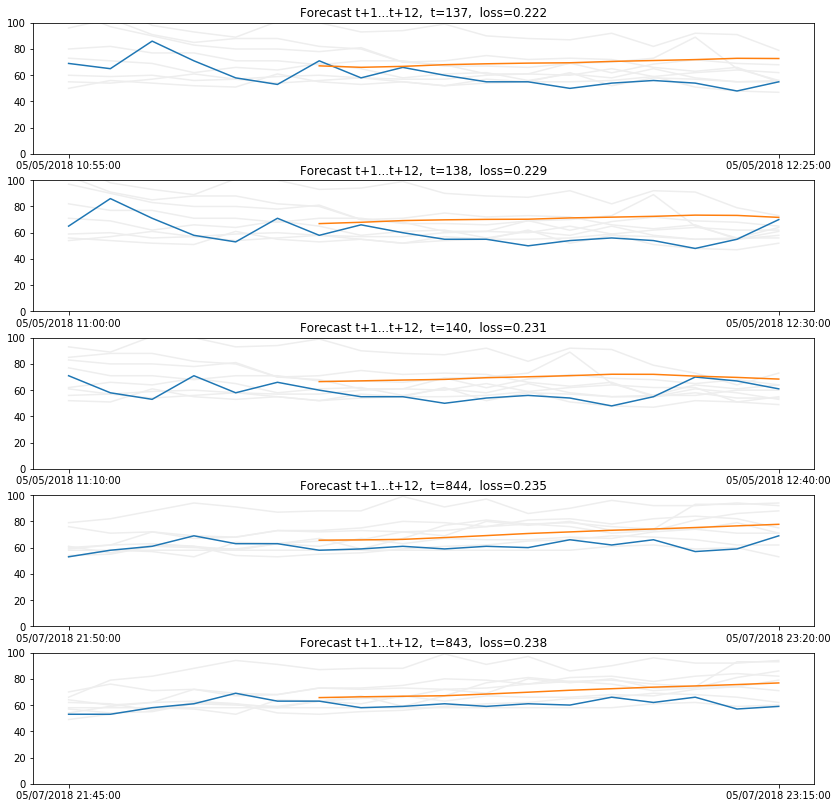

In [103]:
plt.figure(figsize=(14, 14))
for ii, start in enumerate(best2worst[:5]):
    plt.subplot(5, 1, ii+1)
    plot_forecast(start, all_fcasts[start], all_losses[start], subplot=True)
plt.show()
plt.close()

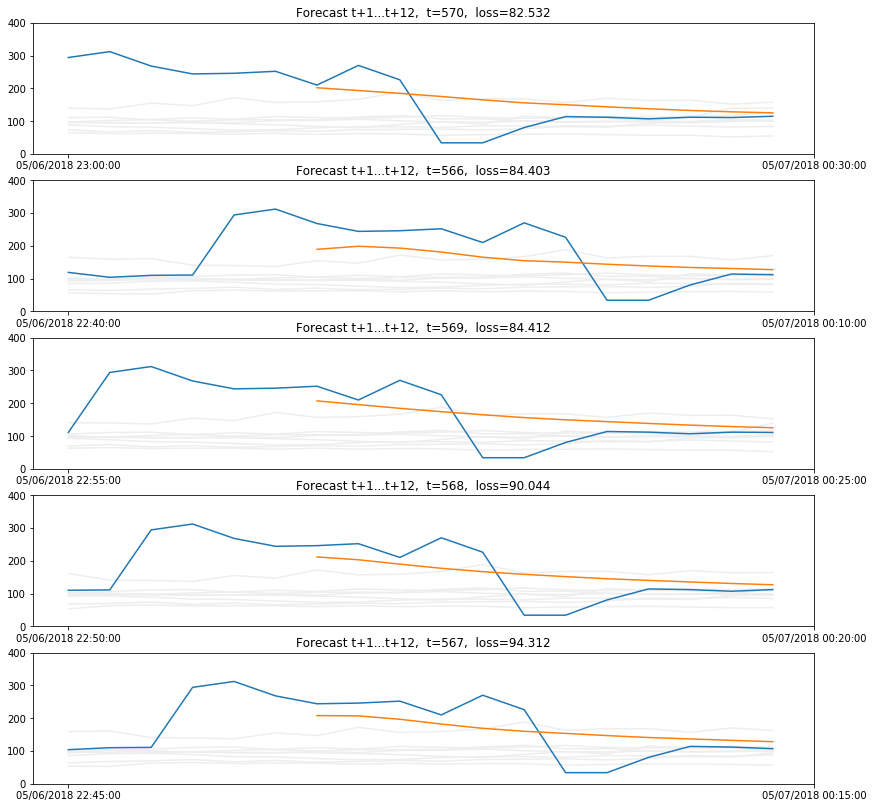

In [98]:
plt.figure(figsize=(14, 14))
for ii, start in enumerate(best2worst[-5:]):
    plt.subplot(5, 1, ii+1)
    plot_forecast(start, all_fcasts[start], all_losses[start], subplot=True, ylim=(0, 400))
plt.show()
plt.close()

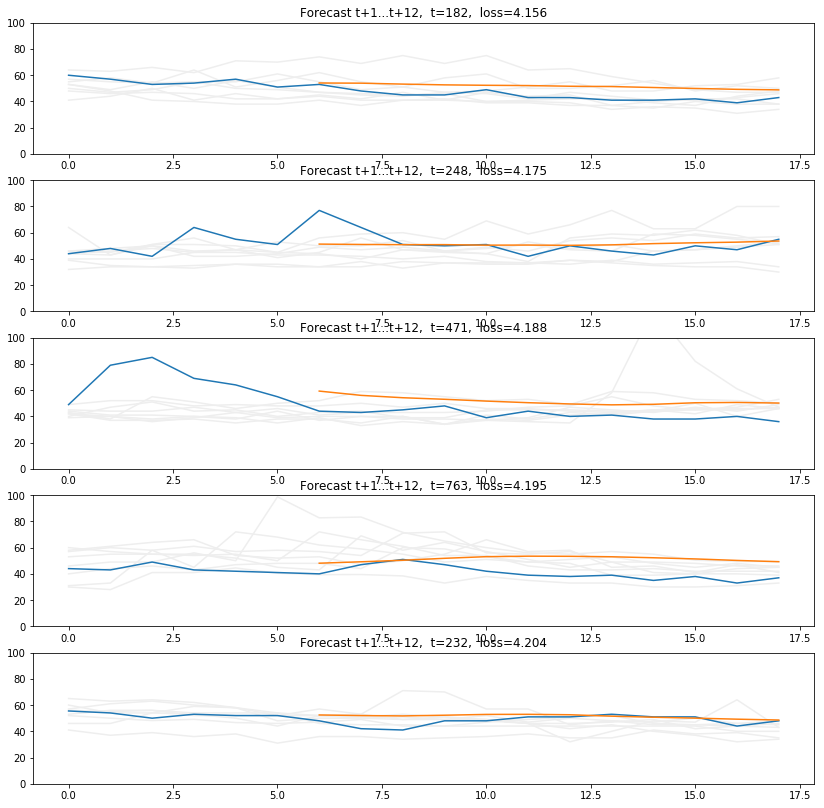

In [92]:
plt.figure(figsize=(14, 14))
for ii, start in enumerate(best2worst[350:355]):
    plt.subplot(5, 1, ii+1)
    plot_forecast(start, all_fcasts[start], all_losses[start], subplot=True)
plt.show()
plt.close()

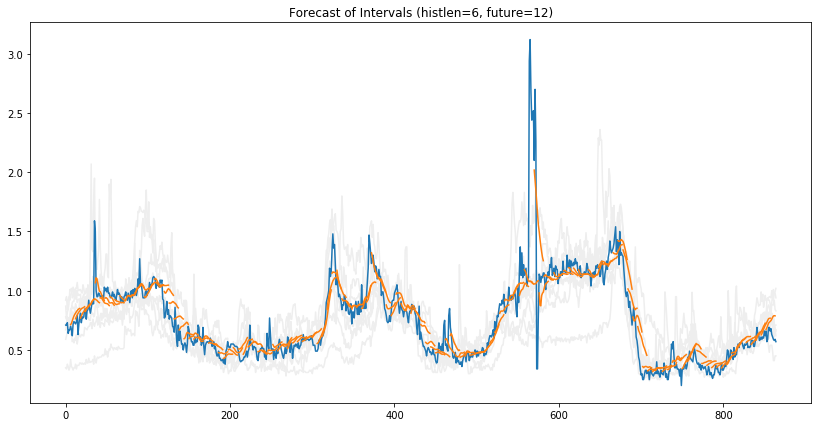

In [107]:
# next_preds = []
# lastii = test_data.shape[1] - HISTLEN
# for ii in range(0, lastii):
#     input = test_data[:, ii:ii+HISTLEN]
#     input = np.transpose(input, [1, 0]) # seq first order
#     input = torch.from_numpy(input).unsqueeze(1) # add batch axis in middle
#     state = seq.init_lstms(batch=1)
#     ypred, _ = seq(input, state)
#     next_preds.append(ypred)
    
#     sys.stdout.write('[%d/%d] Next value predictions...     \r' % (ii+1, lastii))

plt.figure(figsize=(14, 7))
plt.gca().set_title('Forecast of Intervals (histlen=%d, future=%d)' % (HISTLEN, FUTURE))
for sii, seg in enumerate(test_data):
    if sii == TARGET: continue
    plt.plot(seg, color='#EEEEEE')
plt.plot(test_data[TARGET], color='C0')

for ii in range(0, lastii, HISTLEN):
    ypreds = all_fcasts[ii]
    plt.plot(list(range(ii+HISTLEN, ii+HISTLEN+len(ypreds))), ypreds, color='C1')
plt.show()
plt.close()

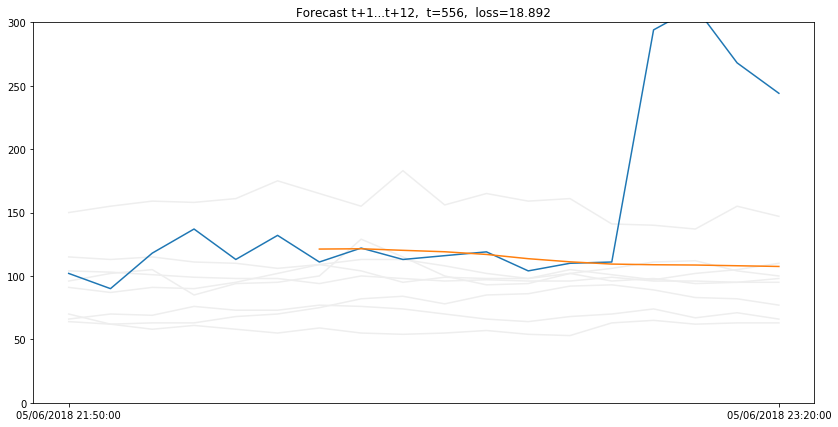

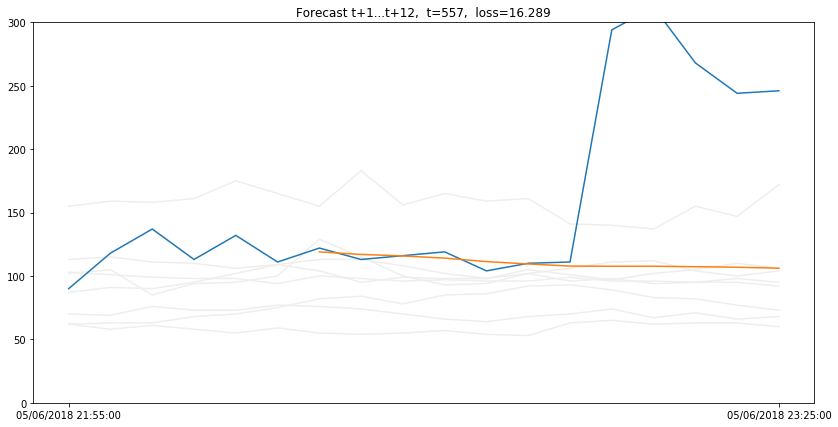

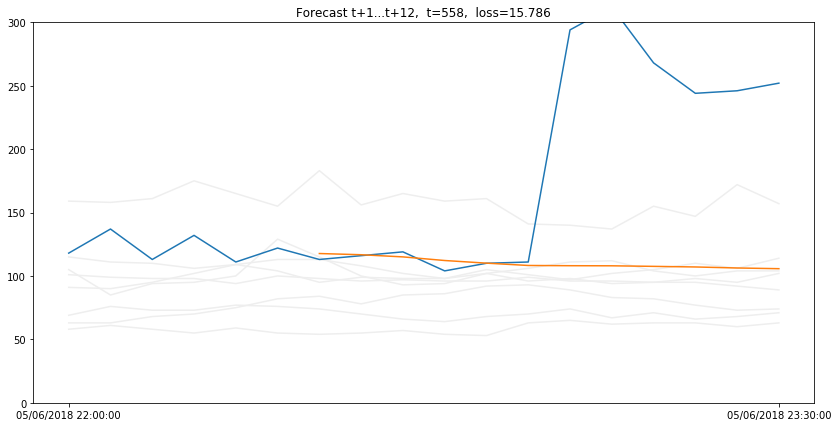

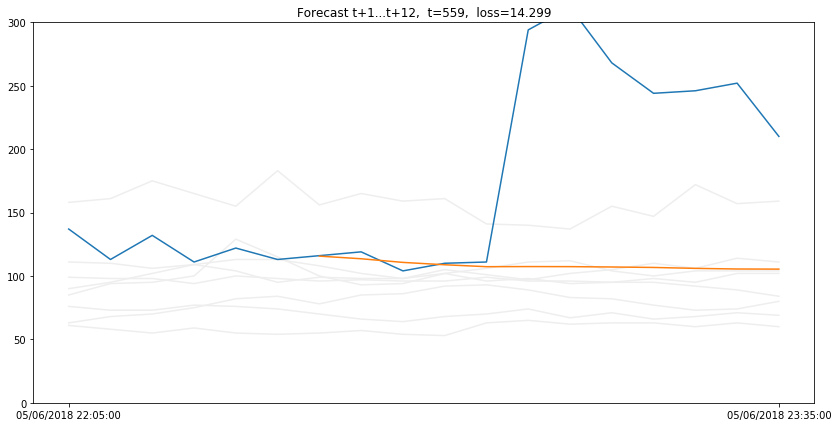

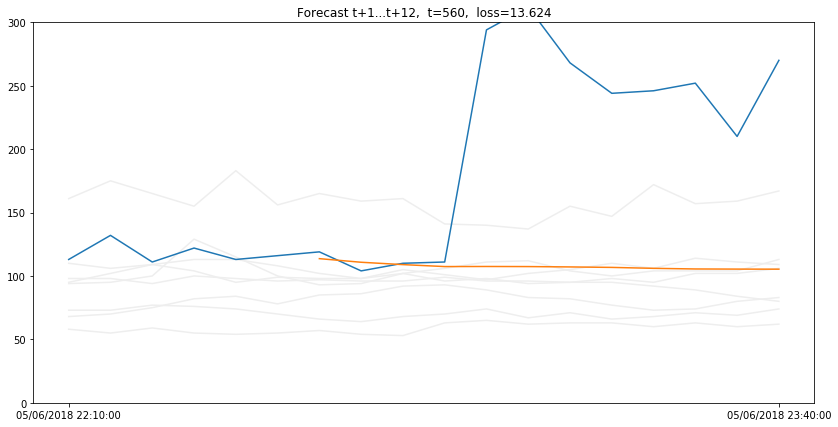

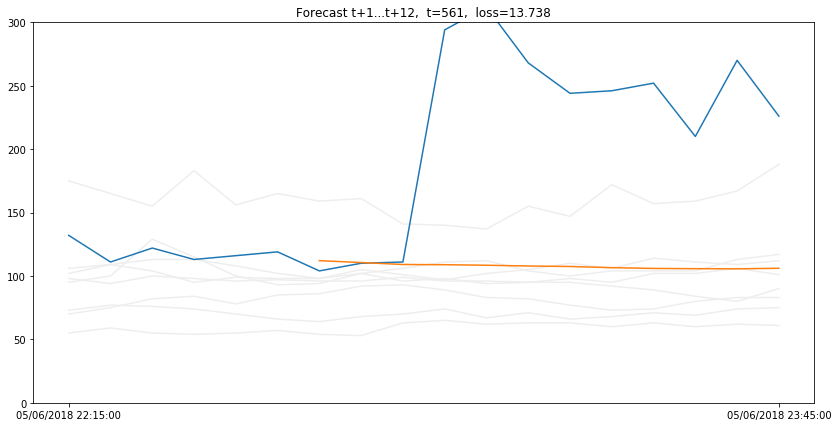

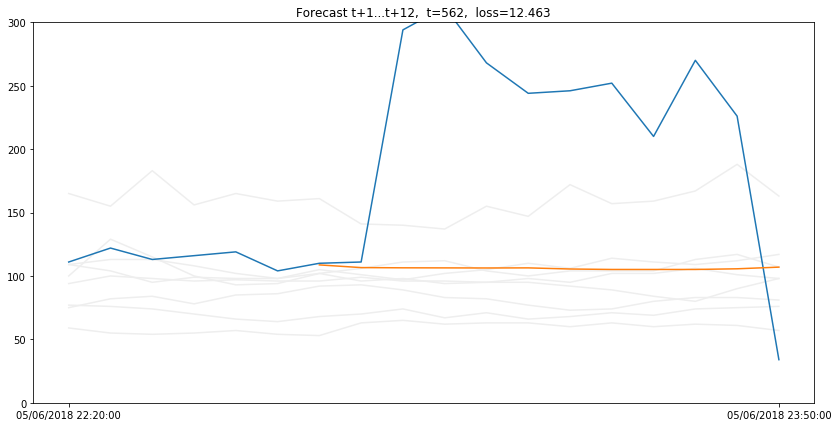

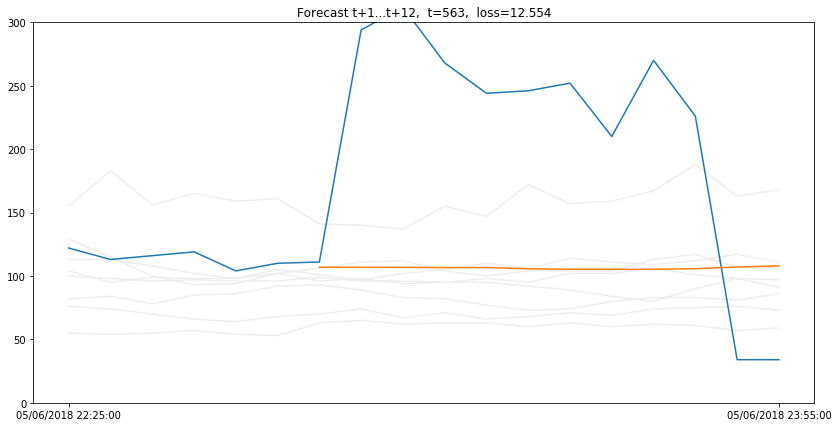

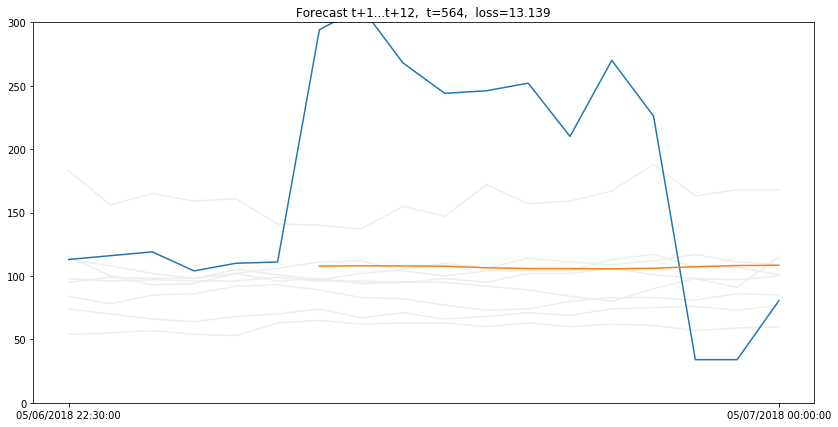

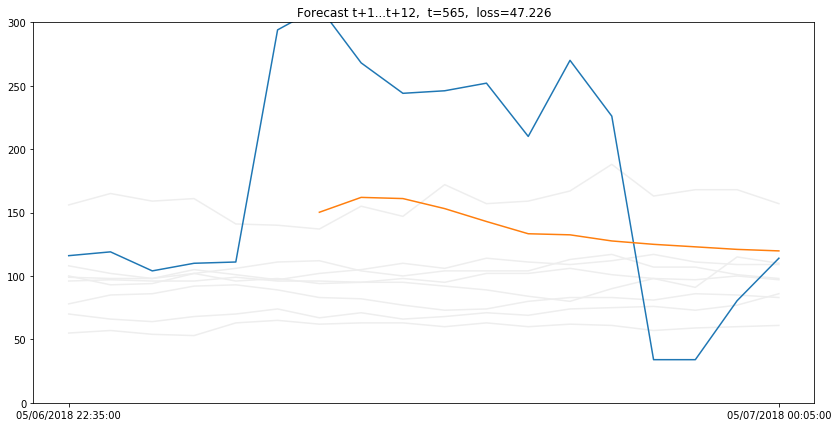

In [111]:
for ii in range(10):
    plot_forecast(550+ii, all_fcasts[550+ii], all_losses[550+ii], subplot=False, ylim=(0, 300))

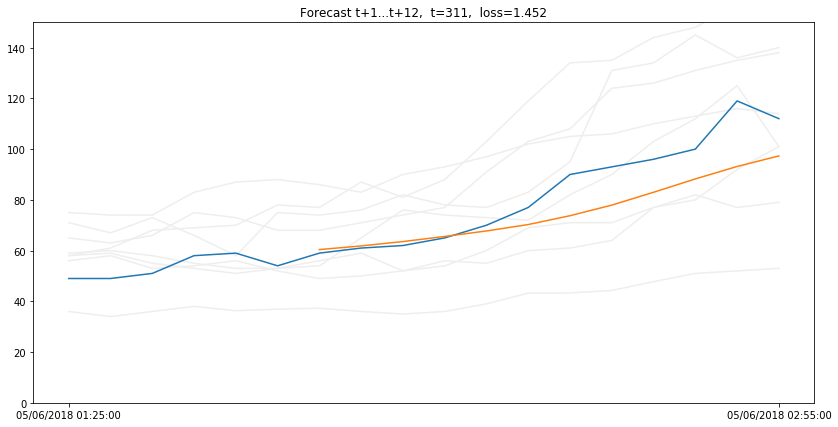

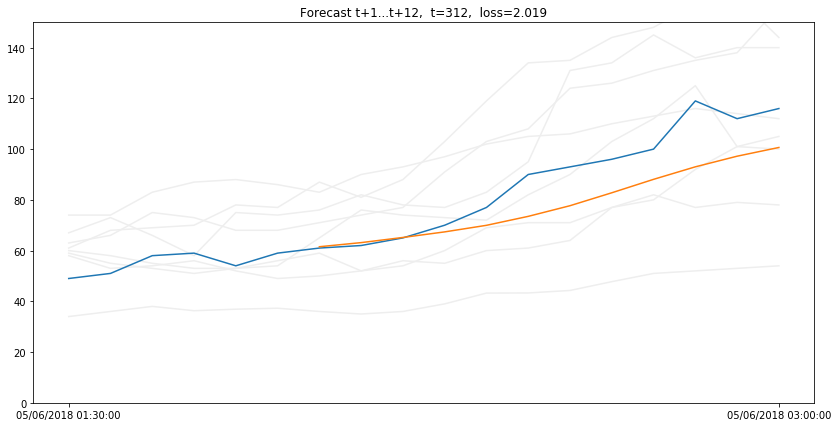

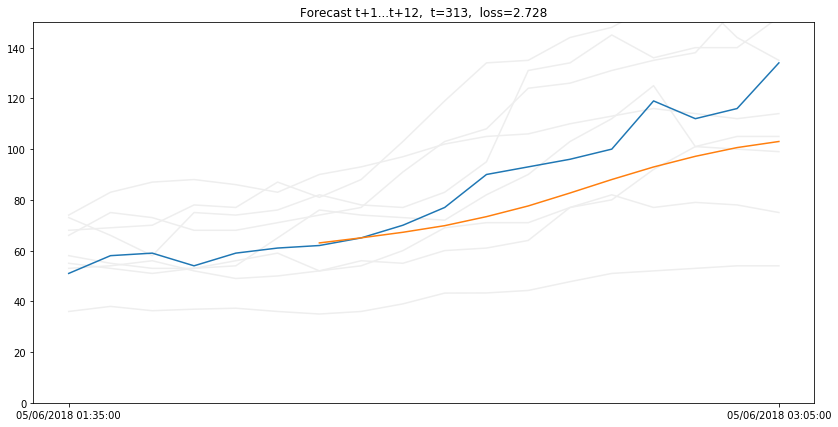

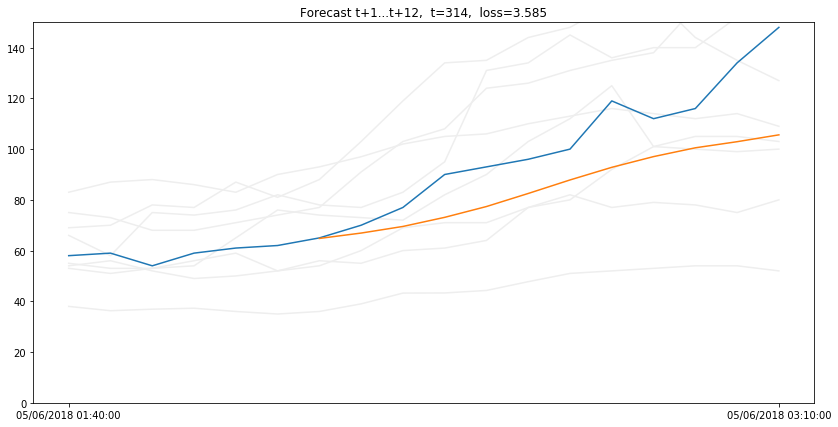

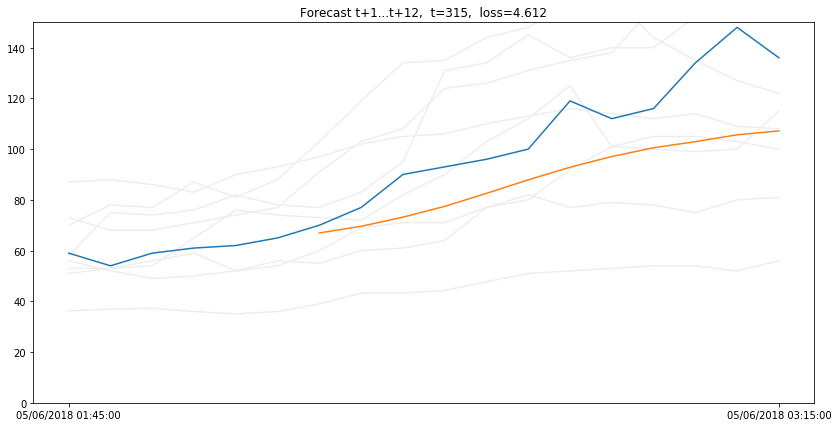

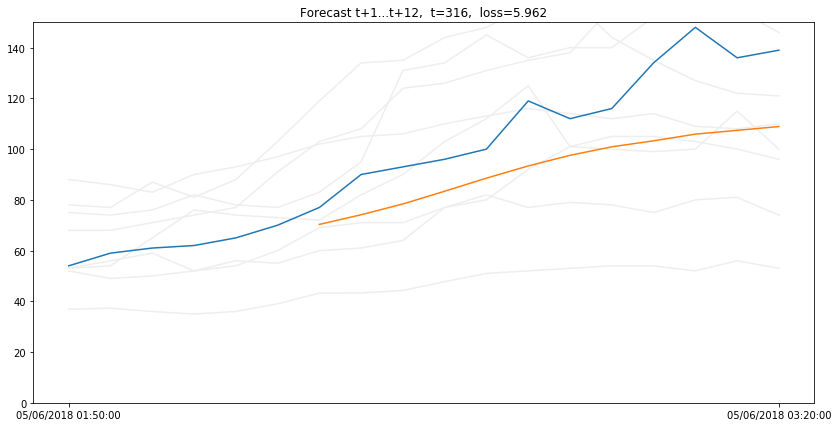

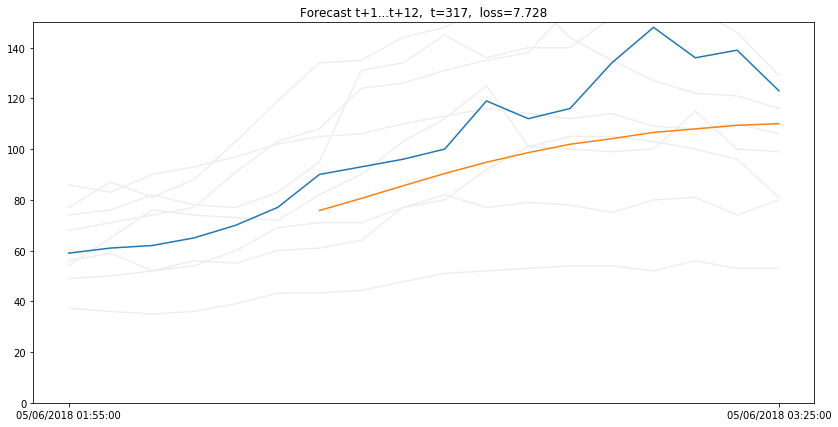

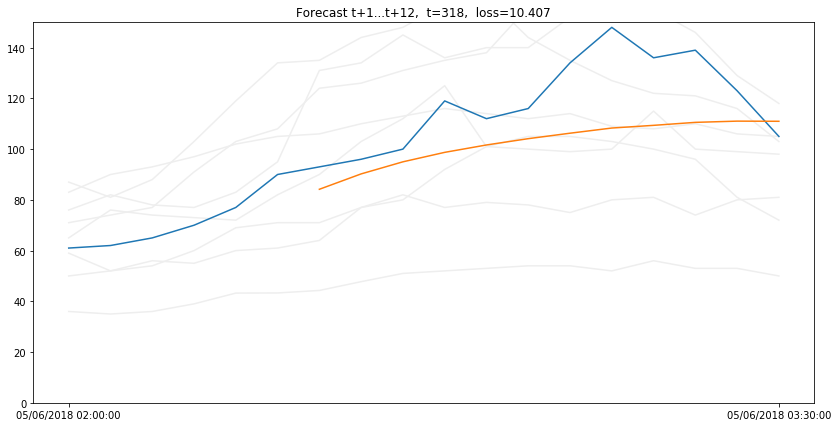

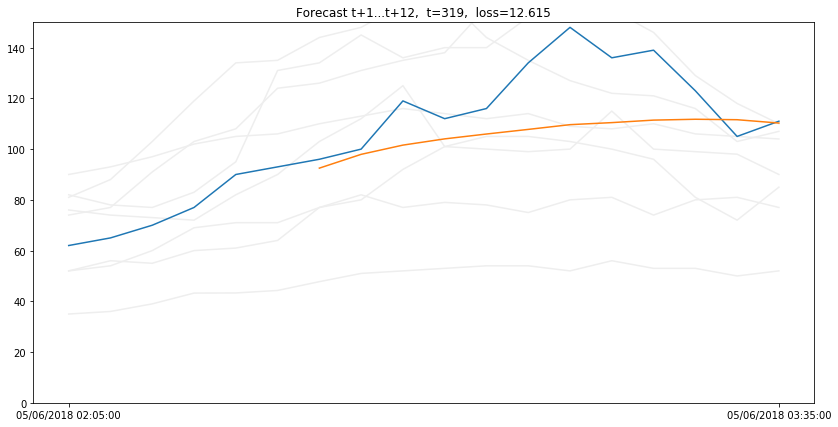

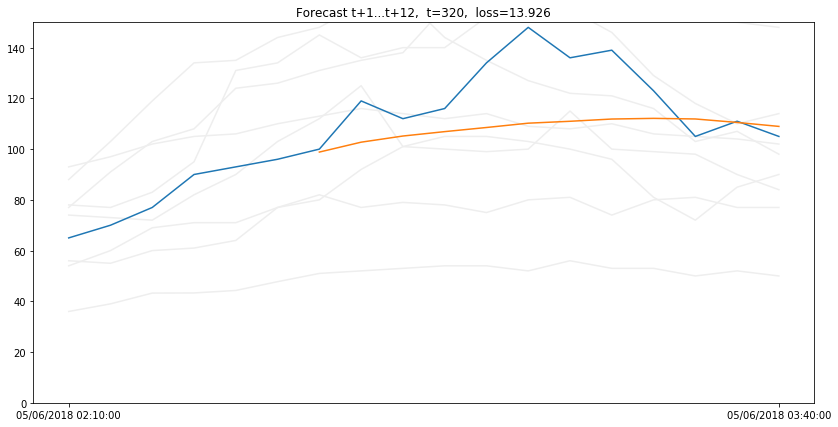

In [118]:
jj = 305
for ii in range(10):
    plot_forecast(jj+ii, all_fcasts[jj+ii], all_losses[jj+ii], subplot=False, ylim=(0, 150))